In [1]:
#!pip install ujson

In [31]:
import ujson as json
import pandas as pd
import numpy as np
from collections import Counter
import pickle as pickle
import random
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import re
import unicodedata

import tensorflow
from tensorflow.keras.layers import Input, Embedding, Dot, Reshape, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE

In [2]:
# loading data from local folder
df = pd.read_json('wp_movies_10k.ndjson', lines=True)
df.columns=['movie', 'info', 'links', 'rating1', 'rating2']

In [3]:
df

,movie,info,links,rating1,rating2
0,Deadpool (film),"{'image': 'Deadpool poster.jpg', 'name': 'Dead...","[Tim Miller (director), Simon Kinberg, Ryan Re...",84%,6.9/10
1,The Revenant (2015 film),"{'image': 'The Revenant 2015 film poster.jpg',...","[Alejandro González Iñárritu, Arnon Milchan, S...",82%,7.9/10
2,Suicide Squad (film),"{'image': 'Suicide Squad (film) Poster.png', '...","[David Ayer, Charles Roven, Richard Suckle, Wi...",26%,4.7/10
3,Spectre (2015 film),"{'image': 'spectre poster.jpg', 'name': 'Spect...","[Sam Mendes, Michael G. Wilson, Barbara Brocco...",65%,
4,Rebel Without a Cause,"{'distributor': 'Warner Bros.', 'image': 'Rebe...","[Nicholas Ray, David Weisbart, Stewart Stern, ...",96%,
...,...,...,...,...,...
9995,Prelude to a Kiss (film),"{'image': 'PreludeKissPoster.jpg', 'name': 'Pr...","[Norman René, Michael Gruskoff, Craig Lucas, A...",61%,
9996,The Black Balloon (film),{'image': 'TheBlackBalloon_Official-Poster.jpg...,"[Elissa Down, Jimmy Jack, Rhys Wakefield, Luke...",88%,
9997,Freelancers (film),"{'image': 'Freelancers (film).jpg', 'name': 'F...","[Jessy Terrero, Mark Canton, 50 Cent, Cheetah ...",None,None
9998,Difret,"{'image': 'Difret poster.jpg', 'name': 'Difret...","[Dave Eggar, 2014 Sundance Film Festival, The ...",None,None


# Movies and links

In [4]:
# Example of links for a movie
print(len(df['links'][1]))
df['links'][1][0:50]

342


['Alejandro González Iñárritu',
 'Arnon Milchan',
 'Steve Golin',
 'Mary Parent',
 'Keith Redmon',
 'James W. Skotchdopole',
 'Mark L. Smith',
 'The Revenant (novel)',
 'Michael Punke',
 'Leonardo DiCaprio',
 'Tom Hardy',
 'Domhnall Gleeson',
 'Will Poulter',
 'Ryuichi Sakamoto',
 'Alva Noto',
 'Emmanuel Lubezki',
 'Stephen Mirrione',
 '20th Century Fox',
 'TCL Chinese Theatre',
 'British Board of Film Classification',
 'TheWrap',
 'Box Office Mojo',
 'Regency Enterprises',
 'RatPac-Dune Entertainment',
 'Anonymous Content',
 'Appian Way Productions',
 'Biographical film',
 'Business Insider',
 'Western (genre)',
 'Alejandro González Iñárritu',
 'Mark L. Smith',
 'Michael Punke',
 'The Revenant (novel)',
 'frontiersman',
 'Hugh Glass',
 'Leonardo DiCaprio',
 'Tom Hardy',
 'Domhnall Gleeson',
 'Will Poulter',
 'Akiva Goldsman',
 'Principal photography',
 'TCL Chinese Theatre',
 'limited release',
 'wide release',
 'cinematography',
 'Golden Globe Awards',
 'BAFTA Awards',
 '88th Academy

In [5]:
# Counting the total number of links
all_links = []

for i in range(len(df)):
    for link in df['links'][i]:
        all_links.append(link)
print('Total number of links in dataframe: ', len(all_links))

Total number of links in dataframe:  1135559


In [6]:
# Counting the number of occurrences of each link
link_counter = Counter(all_links)
common_links = link_counter.most_common()

print('Number of unique links: ', len(common_links))
print('Most common links:')
common_links[0:20]

Number of unique links:  218029
Most common links:


[('Rotten Tomatoes', 9393),
 ('Category:English-language films', 5882),
 ('Category:American films', 5867),
 ('Variety (magazine)', 5450),
 ('Metacritic', 5112),
 ('Box Office Mojo', 4186),
 ('The New York Times', 3818),
 ('The Hollywood Reporter', 3553),
 ('Roger Ebert', 2707),
 ('Los Angeles Times', 2454),
 ('Entertainment Weekly', 2375),
 ('British Board of Film Classification', 2236),
 ('Chicago Sun-Times', 1826),
 ('Deadline.com', 1814),
 ('The Guardian', 1528),
 ('American Film Institute', 1516),
 ('DVD', 1502),
 ('Category:Indian films', 1452),
 ('Warner Bros.', 1424),
 ('New York City', 1293)]

In [7]:
# Let's see how many links are found only once
n = 0
for i in common_links:
    if i[1] == 1:
        n += 1
        
print('Number of links appearing only once: ', n)

Number of links appearing only once:  116217


In [8]:
# Let's take only links that appear more than once
remaining_links = [link for link, count in link_counter.items() if count > 1]
print('Number of remaing links: ', len(remaining_links))

Number of remaing links:  101812


In [9]:
# Creating indexes for unique links
link2index = {link: i for i, link in enumerate(remaining_links)}
index2link = {i: link for link, i in link2index.items()}

print('First links:') 
list(link2index)[0:10]

First links:


['Tim Miller (director)',
 'Simon Kinberg',
 'Ryan Reynolds',
 'Lauren Shuler Donner',
 'Rhett Reese',
 'Paul Wernick',
 'Deadpool',
 'Rob Liefeld',
 'Morena Baccarin',
 'Ed Skrein']

In [10]:
# Creating indexes for movies
movie2index = {movie: i for i, movie in enumerate(df['movie'])}
index2movie = {i: movie for movie, i in movie2index.items()}

print('Number of movies: ', len(movie2index))
print('First movies:')
list(movie2index)[0:10]

Number of movies:  10000
First movies:


['Deadpool (film)',
 'The Revenant (2015 film)',
 'Suicide Squad (film)',
 'Spectre (2015 film)',
 'Rebel Without a Cause',
 'Warcraft (film)',
 'The Martian (film)',
 'List of Marvel Cinematic Universe films',
 'X-Men (film series)',
 'The Hateful Eight']

In [11]:
# Let's save a dictionary for movies
save_file = open('movies2index.pkl', 'wb')
pickle.dump(movie2index, save_file)
save_file.close()

In [12]:
# Creating a dictionary movie-country
movie2country = {}
for i, movie in enumerate(df['movie']):
    country = df['info'][i].get('country')
    
    if country != None:
        country = re.sub(r'http\S+', '', country)
        
    movie2country[movie] = country

Rating

In [13]:
# Creating a dictionary movie-rating
# Rating is taken as avearge mean of two available ratings

movie2raiting = {}
for i in range(len(df)):
    r = None
    
    movie = df['movie'][i]
    r1 = df['rating1'][i]
    r2 = df['rating2'][i]

    if r1 not in ['',  None]:
        if r2 not in ['',  None]:
            r1 = float(re.sub(r'%', '', r1))/10
            r2 = float(re.sub(r'\/\d', '', r2))
            r = round((r1+r2)/2, 1)
        else: 
            r1 = float(re.sub(r'%', '', r1))/10
            r = round(r1, 1)
    elif r2 not in ['',  None]:
        r2 = float(re.sub(r'\/\d', '', r2))
        r = round(r2, 1)
        
    movie2raiting[movie] = r

In [14]:
# Example of average rating for 10 movies
list(movie2raiting.values())[0:10]

[7.7, 8.1, 3.7, 6.5, 9.6, 3.5, None, None, None, 7.4]

In [15]:
# Save a dictionary for rating
save_file = open('movie2raiting.pkl', 'wb')
pickle.dump(movie2raiting, save_file)
save_file.close()

# Pairs movie-link

In [16]:
# Composing pairs movie-link
pairs = []
for i, movie in enumerate(df['movie']):
    links = df['links'][i]
    for link in links:
        if link in link2index.keys():
            pairs.append((movie2index[movie], link2index[link]))
            
print('Number of pairs: ', len(pairs))

Number of pairs:  1019342


In [17]:
# Example of one pair
p = pairs[3]
print('Pair: ', p)
print('Movie: %s, Link: %s' % (index2movie[p[0]], index2link[p[1]]))

Pair:  (0, 3)
Movie: Deadpool (film), Link: Lauren Shuler Donner


In [18]:
# Set of non-repeating pairs
set_pairs = set(pairs)
print('Number of set pairs: ', len(set_pairs))

Number of set pairs:  727866


# Embedding Model

In [19]:
def build_model(embedding_size = 50):
    '''Build a model for creating embeddings'''

    # Both inputs have dimension 1
    movie = Input(name = 'movie', shape = [1])
    link = Input(name = 'link', shape = [1])

    # Embeddings for movies (None, 1, 50)
    movie_embedding = Embedding(name = 'movie_embedding',
                               input_dim = len(movie2index),
                               output_dim = embedding_size)(movie)

    # Embeddings for links (None, 1, 50)
    link_embedding = Embedding(name = 'link_embedding',
                               input_dim = len(link2index),
                               output_dim = embedding_size)(link)
    
    # Merging layers using Dot along the second axis
    # (None, 1, 1)
    merged = Dot(name = 'dot_product', normalize = True, 
                 axes = 2)([movie_embedding, link_embedding])
    
    # Reshape to number (None, 1)
    merged = Reshape(target_shape = [1])(merged)
    
    # Outputs for classification
    out = Dense(1, activation = 'sigmoid')(merged)
    model = Model(inputs = [movie, link], outputs = out)
    
    # Compilation
    model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', 
                  metrics = ['accuracy'])
    
    return model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
link (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 50)        500000      movie[0][0]                      
__________________________________________________________________________________________________
link_embedding (Embedding)      (None, 1, 50)        5090600     link[0][0]                       
_______________________________________________________________________________________

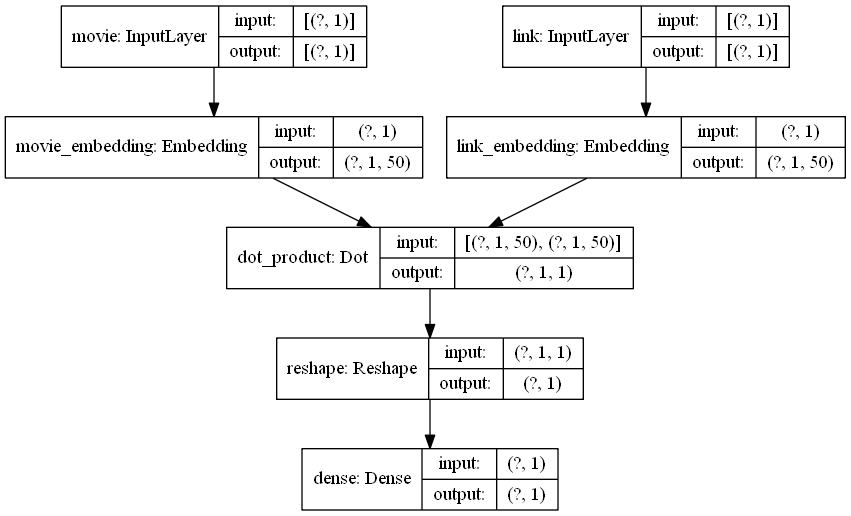

In [20]:
# Build and visualize the model
dim_embedding = 50   # dimension of embeddings
model = build_model(embedding_size = dim_embedding)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Training batches

In [21]:
random.seed(2021)

def batch_generator(pairs, n_positive = 50, negative_ratio = 1.0):
    '''Generate batches for training the model.
    Randomly select positive and negative pairs'''
    
    # Empty array for batches
    batch_size = int(n_positive * (1 + negative_ratio))
    batch = np.zeros((batch_size, 3))
    
    # Running until it gives yield
    while True:
        # Randomly select positive pairs
        for idx, (movie_id, link_id) in enumerate(random.sample(pairs, n_positive)):
            batch[idx, :] = (movie_id, link_id, 1)
        idx += 1
        
        # Adds negative pairs intil the batch is full
        while idx < batch_size:
            
            # Randomly select a movie and a link
            random_movie = random.randrange(len(movie2index))
            random_link = random.randrange(len(link2index))
            
            # Checking that this is not a positive pair
            if (random_movie, random_link) not in set_pairs:
                
                # Add to batch and increase the index
                batch[idx, :] = (random_movie, random_link, -1)
                idx += 1
                
        # Shuffle positive and negative pairs
        np.random.shuffle(batch)
        yield {'movie': batch[:, 0], 'link': batch[:, 1]}, batch[:, 2]

In [22]:
# Example of a batch
next(batch_generator(pairs, n_positive=3))

({'movie': array([8189., 4052.,  567., 7856., 2639., 8914.]),
  'link': array([  353., 83233., 58127.,   181.,  5433., 36269.])},
 array([ 1., -1., -1.,  1.,  1., -1.]))

In [23]:
def check_pair(N_movie, N_link):
    '''Check whether the link belongs to a positive or negative class'''
    m = index2movie[N_movie]
    l = index2link[N_link]
    print('Movie: ', m)
    print('Link: ', l)

    if l in list(df[df['movie'] == m]['links'])[0]:
        print('Link IS in the links for the movie')
    else:
        print('Link IS NOT in the links for the movie')

In [24]:
# Positive pair from a batch
check_pair(7856, 181)

Movie:  The Hills Have Eyes Part II
Link:  Rotten Tomatoes
Link IS in the links for the movie


In [25]:
# Negative pair from a batch
check_pair(8914, 36269)

Movie:  Paulie
Link:  Leonardo Cimino
Link IS NOT in the links for the movie


In [26]:
# Let's look at the time of batch formation
%time next(batch_generator(pairs, 1024, negative_ratio = 2))

Wall time: 10 ms


({'movie': array([2412., 8737., 5100., ..., 9652., 6097., 6611.]),
  'link': array([80691., 73334., 34790., ..., 10240., 26264.,   216.])},
 array([-1., -1., -1., ..., -1., -1.,  1.]))

# Model training

In [28]:
# If there is already a saved model, you can load it in the next cell and do not execute this cell.
n_positive = 1024
start = time()

model.fit(batch_generator(pairs, n_positive, negative_ratio = 2),
          epochs=15,
          steps_per_epoch=len(pairs) // n_positive)

print('Training time (s): ', round((time()-start), 1))

# Сохраним обученную модель
model.save('model_movies50.h5')

Epoch 1/15
995/995 [==============================] - 41s 42ms/step - loss: 0.1518 - accuracy: 0.0335
Epoch 2/15
995/995 [==============================] - 41s 41ms/step - loss: -1.6387 - accuracy: 0.1233
Epoch 3/15
995/995 [==============================] - 41s 41ms/step - loss: -2.6628 - accuracy: 0.1228
Epoch 4/15
995/995 [==============================] - 41s 41ms/step - loss: -3.5894 - accuracy: 0.1214
Epoch 5/15
995/995 [==============================] - 42s 42ms/step - loss: -4.5189 - accuracy: 0.1209
Epoch 6/15
995/995 [==============================] - 46s 46ms/step - loss: -5.4497 - accuracy: 0.1206
Epoch 7/15
995/995 [==============================] - 43s 44ms/step - loss: -6.3880 - accuracy: 0.1207
Epoch 8/15
995/995 [==============================] - 54s 55ms/step - loss: -7.3173 - accuracy: 0.1201 0s - loss: -7.3107 - accu
Epoch 9/15
995/995 [==============================] - 53s 53ms/step - loss: -8.2520 - accuracy: 0.1199
Epoch 10/15
995/995 [===========================

In [27]:
# Load saved model
model = load_model('model_movies50.h5')

# Embeddings for movies

In [28]:
# Extract embeddings for movies
movie_layer = model.get_layer('movie_embedding')
movie_weights = movie_layer.get_weights()[0]

print('Shape of movie_weights: ', movie_weights.shape)

Shape of movie_weights:  (10000, 50)


In [32]:
# Example of a vector for the first movie
movie_weights[0]

array([ 0.0418242 , -0.02052009,  0.02174377,  0.0076357 , -0.19993359,
        0.18604207,  0.13532118, -0.15526845, -0.23236313,  0.14569525,
        0.01716411, -0.19625987, -0.01444102, -0.08988577, -0.12782997,
       -0.12471138,  0.2062665 ,  0.16034566,  0.1148356 , -0.04216724,
       -0.17057762,  0.17105554, -0.10108502,  0.03247864,  0.10365362,
        0.12748398, -0.08641721,  0.19331525, -0.06054003,  0.2053946 ,
       -0.08018017,  0.00872615, -0.04881294,  0.16948715,  0.09989719,
       -0.10145294,  0.04757867, -0.08964101,  0.06963997, -0.17950138,
        0.15732975, -0.13645548,  0.12252954, -0.12832515, -0.16343807,
       -0.1682988 , -0.2182681 , -0.02056713, -0.00872661,  0.02905894],
      dtype=float32)

In [33]:
# Save embeddings for movies
save_file = open('movies_emb50.pkl', 'wb')
pickle.dump(movie_weights, save_file)
save_file.close()

In [34]:
def similar_movies(movie):
    '''
    The cosine distance between normalized embeddings for a given movie and other movies is calculated.
    Ten closest films are selected.
    '''
    # Calculating the distances
    distances = cosine_similarity(movie_weights, [movie_weights[movie2index[movie]]])[:,0]

    # indexes for the ten nearest movies
    similar = np.argsort(distances)[-10:]

    # Display the movie index, title and distance to the specified movie
    for k in reversed(similar):
        print(k, df['movie'][k], distances[k])

In [35]:
# An example of finding similar movies
similar_movies('Youth (2015 film)')

288 Youth (2015 film) 0.99999994
9206 Certified Copy (film) 0.99883217
6100 In a Better World 0.99857354
4322 A Very Long Engagement 0.9983497
6594 The Broken Circle Breakdown 0.99831647
1362 Mustang (film) 0.9983088
5783 Brideshead Revisited (film) 0.99819344
1588 A Royal Affair 0.9981095
6991 Chronic (film) 0.99807477
6743 Europa Europa 0.99804366


In [36]:
# Entertainment movies
similar_movies('Deadpool (film)')

0 Deadpool (film) 1.0
182 The Amazing Spider-Man 2 0.99613637
20 Ant-Man (film) 0.9931088
39 Guardians of the Galaxy (film) 0.9923756
42 The Avengers (2012 film) 0.9908686
67 DC Extended Universe 0.9900319
1364 Captain America: Civil War 0.9898749
34 Doctor Strange (film) 0.98911315
372 The Amazing Spider-Man (2012 film) 0.9884423
22 Jurassic World 0.98837024


In [37]:
# Getting Indian movies by specifying an Indian movie
similar_movies('Mayabazar')

7534 Mayabazar 1.0
2227 Rang De Basanti 0.986467
483 Ennu Ninte Moideen 0.9836886
9790 Gemini (2002 Tamil film) 0.97724694
3013 Anniyan 0.97617364
1691 Manam (film) 0.9755783
2679 Govindudu Andarivadele 0.97436744
3373 Vaaranam Aayiram 0.97266895
2047 Magadheera 0.97149247
2666 Mankatha 0.97045255


In [38]:
def get_X(movies_list):
    '''Returns vectors for a list of movies'''
    X = np.zeros((len(movies_list), dim_embedding))

    for i, movie in enumerate(movies_list):
        X[i] = movie_weights[movie2index[movie]]

    return X   

def plot_tsne(movies_list, labels=False):
    '''For a given list of movies, it shows on the graph the location of their vectors 
    using the TSNE transformation'''
    
    X = get_X(movies_list)
    tsne = TSNE(n_components=2, random_state=2021)
    X_reduced = tsne.fit_transform(X)

    plt.figure(figsize=(16,10))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], color='blue')
    
    # Adding movie titles to the showed points
    if labels:
        for label, x, y in zip(movies_list, X_reduced[:, 0], X_reduced[:, 1]):
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
            
    plt.xlabel('TSNE 1')
    plt.ylabel('TSNE 2')
    plt.title('Arrangement of embeddings using TSNE')
    plt.savefig("Embeddings_TSNE.jpg", dpi=150)
    plt.show()

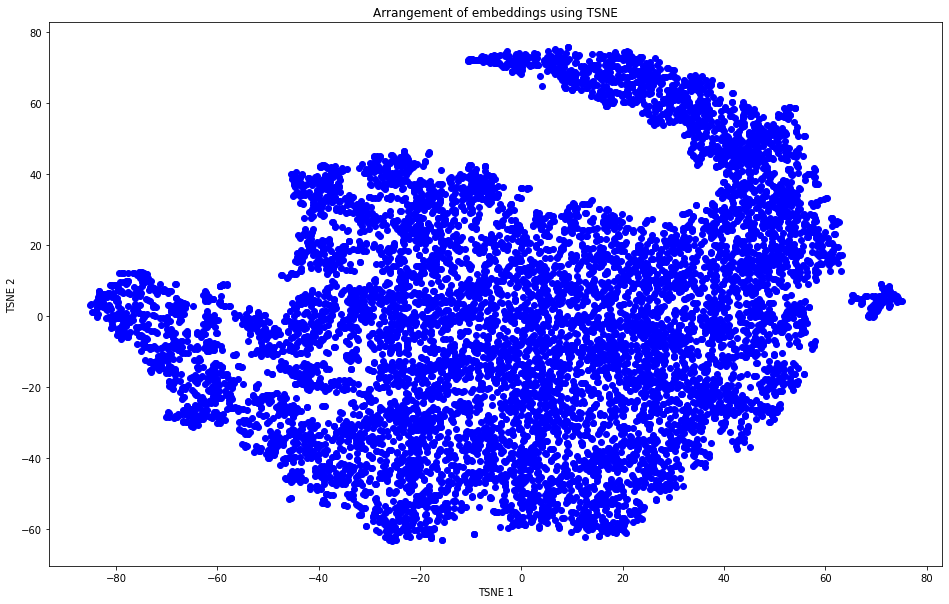

In [39]:
# Let's depict the embeddings of all movies using the TSNE transformation
plot_tsne(list(df['movie']))

In [40]:
# Select movies from several countries
# This division is conditional, since a film can be created with the participation of several countries
movie2country_selected = {}

country_selected = ['United States', 'India', 'South Korea', 'China', 'France', 'Soviet Union',  'Russia']
    
for movie in df['movie']:
    country = movie2country[movie]
        
    if country != None:
        for count in country_selected:
            if count in country:
                movie2country_selected[movie] = count

In [41]:
def plot_tsne_countries(movies_countries):
    '''For a given list of movies, it shows on the graph the location of their vectors 
    using the TSNE transformation.
    Movies from different countries have different colors'''
    
    X = get_X(list(movies_countries))
    tsne = TSNE(n_components=2, random_state=2021)
    X_reduced = tsne.fit_transform(X)
    
    df_country = pd.DataFrame({'movie': movie2country_selected.keys(),
                           'country': movie2country_selected.values(),
                           'tsne1': X_reduced[:, 0], 'tsne2': X_reduced[:, 1]})
    #print(df_country)
    plt.figure(figsize=(16,10))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], color='blue')
    
    sns.scatterplot(data=df_country, x='tsne1', y='tsne2', hue='country', edgecolor='none')
            
    plt.xlabel('TSNE 1')
    plt.ylabel('TSNE 2')
    plt.title('Arrangement of embeddings using TSNE')
    plt.savefig("Embeddings_countries_TSNE.jpg", dpi=150)
    plt.show()

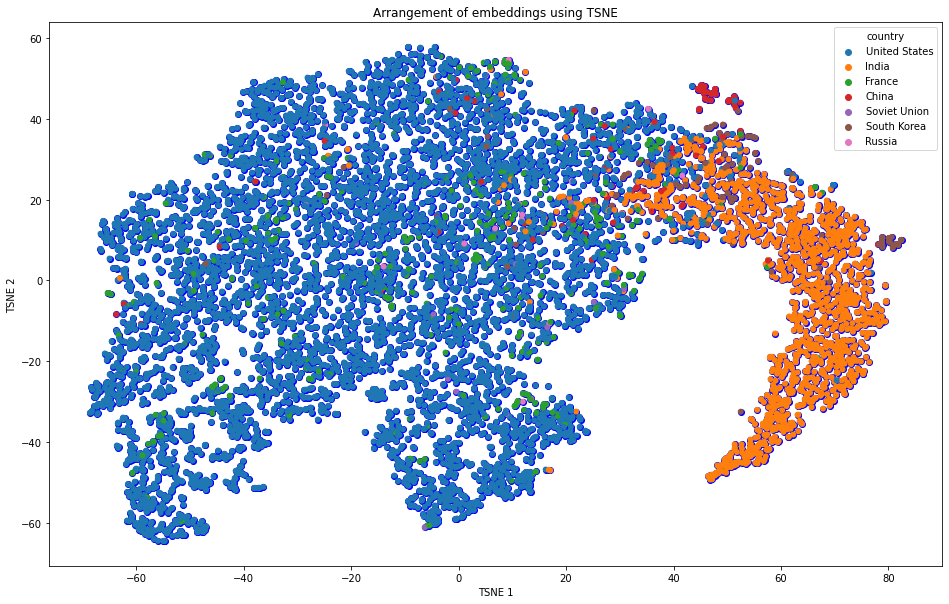

In [42]:
# Let's see embeddings for movies from different countries
plot_tsne_countries(movie2country_selected)

# A group of Indian movies is separated from the main group of movies
# For Chinese movies, two small separate groups are visible
# South Korean films are also in a separate group

# Recommendations based on several movies

In [43]:
# Let's make a list of favorite movies
favorite_movies = ['The Great Beauty', 'The Lobster', 'Spring, Summer, Fall, Winter... and Spring',
                   '3-Iron', 'Stalker (1979 film)', 'Requiem for a Dream', 'Dogville']
# A list of least favorite movies
unliked_movies = ['Avatar (2009 film)', 'Warcraft (film)', '300 (film)',
                   'The Texas Chain Saw Massacre', 'The Conjuring', 'The Conjuring 2']

In [46]:
def prepare_classes(positive_movies, negative_movies):
    '''Create two datasets: favorite and least favorite movies'''
    
    selected_movies = positive_movies + negative_movies
    X = np.zeros((len(selected_movies), dim_embedding))
    Y = np.zeros(len(selected_movies))

    for i, movie in enumerate(selected_movies):
        X[i] = movie_weights[movie2index[movie]]
        if movie in positive_movies:
            Y[i] = 1
        else:
            Y[i] = -1

    return X, Y

In [47]:
X, Y = prepare_classes(favorite_movies, unliked_movies)
print('X shape: ', X.shape)
print('Y shape: ', Y.shape)
print('Examples in positive class: ', len(Y[Y==1]))
print('Examples in negative class: ', len(Y[Y==-1]))

X shape:  (13, 50)
Y shape:  (13,)
Examples in positive class:  7
Examples in negative class:  6


In [48]:
# Take the KNN classifier
# Let's take the number of nearest neighbors more than the number of examples in the positive class
clf = KNeighborsClassifier(n_neighbors=len(favorite_movies)+1,
                           weights='distance', metric='minkowski', p=2)
clf.fit(X, Y)

KNeighborsClassifier(n_neighbors=8, weights='distance')

In [50]:
# Calculate the probability of attribution to the second class (positive)
movie_rating = clf.predict_proba(movie_weights)[0:,1]
# Sorting movie indices by increasing the probability of being classified as a positive class 
sorted_movies = np.argsort(movie_rating)[-20:]

# Top 20 recommended movies (including presets)
print('index - movie\'s name - probability:')
for k in reversed(sorted_movies):
    print(k, df['movie'][k], movie_rating[k])

index - movie's name - probability:
357 Requiem for a Dream 1.0
1753 The Great Beauty 1.0
1548 Stalker (1979 film) 1.0
9187 3-Iron 0.9999999015134741
2070 Dogville 0.9999997722987121
120 The Lobster 0.9999997689121318
5182 Spring, Summer, Fall, Winter... and Spring 0.9999997053583859
9140 Belle Époque (film) 0.9395221803556055
3408 The Mirror (1975 film) 0.9392038567445087
8845 The Measure of a Man (2015 film) 0.9389076957237104
7380 Pandora's Box (1929 film) 0.9388532606639421
8680 Water Lilies (film) 0.9387933379024789
3121 Kes (film) 0.9387671390337714
7456 Dersu Uzala (1975 film) 0.938331437849556
7525 Manon des Sources (1986 film) 0.9381863286008599
9171 L'Eclisse 0.9375897277912796
6651 Malicious (1973 film) 0.9375350607993863
2094 Bicycle Thieves 0.9375200230595384
6528 Through a Glass Darkly (film) 0.9372834695902252
2695 The 400 Blows 0.9371158643208478


In [62]:
def recommendation(positive_movies, negative_movies=[]):
    recommended_movies = []
    mean_rating = []
    
    '''If there is only one movies in one of the classes, or there are no negative movies, 
    then the recommendation is made according to the similarity of the embeddings to the embeddings of the positive class.
    If there are at least two movies in each of the classes, then a KNN classifier is built to recommend movies.
    Rating is also shown for recommended movies.'''
    
    # Only one movie is in a positive class
    if len(positive_movies) == 1:
        movie = positive_movies[0]
        distances = cosine_similarity(movie_weights, [movie_weights[movie2index[movie]]])[:,0]
        similar = np.argsort(distances)[-11:]
        
        for k in reversed(similar):
            mov = index2movie[k]
            recommended_movies.append(mov)
            mean_rating.append(movie2raiting[mov])
        return recommended_movies[1:], mean_rating[1:]
    
    # Several movies are in a positive class
    if len(positive_movies) >= 2:
        
        # One movie is in a negative class and several movies are in a positive class
        if len(negative_movies) < 2:
            X = np.zeros((len(positive_movies), dim_embedding))
            for i, movie in enumerate(positive_movies):
                X[i] = movie_weights[movie2index[movie]]
            # Average value for the vector of ebmeddings
            X = np.mean(X, axis=0)
            
            distances = cosine_similarity(movie_weights, [X])[:,0]
            similar = np.argsort(distances)[-(10+len(positive_movies)):]
            
            for k in reversed(similar):
                mov = index2movie[k]
                if mov not in positive_movies:
                    recommended_movies.append(mov)
                    mean_rating.append(movie2raiting[mov])
            return recommended_movies, mean_rating
        
        # Several movies are in each of the classes
        if len(negative_movies) >= 2:
            X, Y = prepare_classes(positive_movies, negative_movies)
            
            # Train KNN classifier
            clf = KNeighborsClassifier(n_neighbors=len(positive_movies)+1,
                           weights='distance', metric='minkowski', p=2)
            clf.fit(X, Y)
            
            # Calculate the probability of attribution to the second class (positive)
            movie_rating = clf.predict_proba(movie_weights)[0:,1]
            # Sorting movie indices by increasing the probability of being classified as a positive class 
            sorted_movies = np.argsort(movie_rating)[-(10+len(positive_movies)):]

            # Top 10 recommended movies
            for k in reversed(sorted_movies):
                mov = index2movie[k]
                if mov not in positive_movies:
                    recommended_movies.append(mov)
                    mean_rating.append(movie2raiting[mov])
            return recommended_movies, mean_rating

In [60]:
# Example of a recommendation based on two favorite movies
recommendation(favorite_movies[0:2])

(['Two Days, One Night',
  'The Diving Bell and the Butterfly (film)',
  'We Need to Talk About Kevin (film)',
  'The Tribe (2014 film)',
  'Blue Is the Warmest Colour',
  'Clouds of Sils Maria',
  'Love & Friendship',
  'The Hunt (2012 film)',
  'Bright Star (film)',
  'Antichrist (film)'],
 [9.7, 9.3, 7.6, 8.1, 8.6, 8.9, 9.8, 9.4, 8.2, 4.9])

In [59]:
# Example of a recommendation based on favorite and least favorite movies
recommendation(favorite_movies, unliked_movies)

(['Belle Époque (film)',
  'The Mirror (1975 film)',
  'The Measure of a Man (2015 film)',
  "Pandora's Box (1929 film)",
  'Water Lilies (film)',
  'Kes (film)',
  'Dersu Uzala (1975 film)',
  'Manon des Sources (1986 film)',
  "L'Eclisse",
  'Malicious (1973 film)'],
 [None, None, None, 9.0, None, 10.0, None, None, None, None])